In [255]:
import os
from pathlib import Path
import math
from functools import partial

import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
from torch.nn.utils.prune import custom_from_mask
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger
from torch.optim import SGD
import matplotlib.pyplot as plt

from pruneshift.modules import VisionModule
from pruneshift.networks import network as create_network
from pruneshift.datamodules import datamodule
from pruneshift.prune_info import PruneInfo
from pruneshift.prune import prune


DATASET_PATH = os.environ["DATASET_PATH"]
MODEL_PATH = Path(os.environ["MODEL_PATH"])/"augmix"

In [246]:
# TODO  1. DONE
#       2. Find the correct hyper params. Probably higher augmix_alpha during pruning.
#       3. Start a pruning run.

class GetSubnet(autograd.Function):
    @staticmethod
    def forward(ctx, scores, k):
        # Get the subnetwork by sorting the scores and using the top k%
        out = scores.clone()
        _, idx = scores.flatten().sort()
        j = int(k * scores.numel())

        # flat_out and out access the same memory.
        flat_out = out.flatten()
        flat_out[idx[:j]] = 0
        flat_out[idx[j:]] = 1

        return out

    @staticmethod
    def backward(ctx, g):
        # send the gradient g straight-through on the backward pass.
        return g, None


# We do not have the stacking problem :)
class HydraHook:
    def __init__(self, module, name, amount: float):
        self.name = name
        self.amount = amount
        self.module = module
        
        param = getattr(module, name)
        # Register buffers the same way as the pruning model.
        del module._parameters[name]
        module.register_buffer(name + "_orig", param)  # TODO: Should this be a buffer?
        n = nn.init._calculate_correct_fan(param, "fan_in")
        score = math.sqrt(6 / n) * param / torch.max(torch.abs(param))
        module.register_parameter(name + "_score", nn.Parameter(score))
        # nn.init.kaiming_uniform_(getattr(module, name + "_score"), a=math.sqrt(5))
        module.register_buffer(name, torch.zeros_like(param))
        module.register_buffer(name + "_mask", GetSubnet.apply(score, amount))

        module.register_forward_pre_hook(self)

    def __call__(self, module, inputs):
        score = getattr(module, self.name + "_score")
        weight = getattr(module, self.name + "_orig")

        mask = GetSubnet.apply(score.abs(), self.amount)
        setattr(module, self.name + "_mask", mask)
        setattr(module, self.name, mask * weight)

    def remove(self):
        # Make the original param a param again.
        mask = self.module._buffers.pop(self.name + "_mask")
        param = self.module._buffers.pop(self.name + "_orig")
        score = self.module._parameters.pop(self.name + "_score")
        # Register the main buffer.
        del self.module._buffers[self.name]
        self.module.register_parameter(self.name, nn.Parameter(param))
        
        return self.name, mask


def freeze_protected(info, reverse: bool = False):
    for submodule in info.network.modules():
        for name, param in submodule.named_parameters():
            if not info.is_protected(submodule):
                continue
            param.requires_grad = reverse

            
# TODO: We need to freeze the biases of linear layers.
def hydrate(network: nn.Module, ratio: float, init: str = None):
    """ Returns HydraHooks"""
    info = PruneInfo(network, {nn.Linear: ["weight"], nn.Conv2d: ["weight"]})

    amount = info.ratio_to_amount(ratio)
    
    target_pairs = set(info.target_pairs())

    for module, param_name in target_pairs:
        HydraHook(module, param_name, amount)

    # freeze_protected(info)
    # network.fc.bias.requires_grad = False
    return info


def dehydrate(network: nn.Module):
    """ Change the hydrated network to a normal pruned network."""
    # Collects modules, param_names and mask from the hooks.
    info = PruneInfo(network, {nn.Linear: ["weight"], nn.Conv2d: ["weight"]})


    for module in network.modules():
        hooks_to_remove = []
        for k, hook in list(module._forward_pre_hooks.items()):
            param_name, mask = hook.remove()
            custom_from_mask(module, param_name, mask)
            del module._forward_pre_hooks[k]

    # network.fc.bias.requires_grad = True
    # freeze_protected(info, True)


In [276]:
net = create_network("cifar100_resnet18", model_path=MODEL_PATH)
len(list(PruneInfo(net, {nn.Linear: ["weight"], nn.Conv2d: ["weight"]}).target_pairs()))
# net.fc.is_protected = False

20

In [277]:
# info = hydrate(net, 32)
info = prune(net, "layer_weight", 32)

In [279]:
info.network_comp()

32.0000114080695

In [250]:
T = 30
optim_fn = partial(optim.SGD, nesterov=True, weight_decay= 0.0005, momentum= 0.9)
scheduler_fn = partial(optim.lr_scheduler.CosineAnnealingLR, T_max=T)

lr_monitor = LearningRateMonitor(logging_interval='step')
callbacks = [lr_monitor]
trainer = pl.Trainer(gpus=1, max_epochs=12, checkpoint_callback=False, weights_summary=None)

# net.conv1.is_protected = True
# net.fc.is_protected = False
data = datamodule("cifar100_augmix_corrupted", DATASET_PATH, batch_size=128)
# info = hydrate(net, 32)
# info.summary()

GPU available: True, used: True
I0131 11:09:53.801120 140129021425472 distributed.py:49] GPU available: True, used: True
TPU available: False, using: 0 TPU cores
I0131 11:09:53.802911 140129021425472 distributed.py:49] TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
I0131 11:09:53.804030 140129021425472 accelerator_connector.py:402] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


In [251]:
module = VisionModule(net, data.labels, optimizer_fn=optim_fn, learning_rate=0.1, scheduler_fn=scheduler_fn)

trainer.fit(module, datamodule=data)

Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f71273fb668>>
Traceback (most recent call last):
  File "/misc/student/hoffmaja/virtual_environments/theseus/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f71273fb668>>
Traceback (most recent call last):
  File "/misc/student/hoffmaja/virtual_environments/theseus/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/misc/student/hoffmaja/virtual_environments/theseus/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/misc/student/hoffmaja/virtual_environments/theseus/lib/python3.6/site-packages/torch/utils/dat

    self._shutdown_workers()
  File "/misc/student/hoffmaja/virtual_environments/theseus/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers


    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f71273fb668>>
Traceback (most recent call last):
  File "/misc/student/hoffmaja/virtual_environments/theseus/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/misc/student/hoffmaja/virtual_environments/theseus/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f71273fb668>>
Traceback (most recent call last):
  File "/misc/student/hoffmaja/virtual_environments/theseus/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/misc/student/hoffmaja/virtual_environments/theseus/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1162, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/usr/lib/python3.6/threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f71273fb668>>
Traceback (most recent call last):
  File "/misc/student/hoffmaja/virtual_environments/theseus/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/misc/student/hoffmaja/virtual_environments/theseus/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


1

In [253]:
from copy import deepcopy

netto = deepcopy(net)



RuntimeError: Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment

In [254]:
dehydrate(net)
trainer = pl.Trainer(gpus=1, max_epochs=12, checkpoint_callback=False, weights_summary=None)

trainer.fit(module, datamodule=data)
# trainer.test(module, datamodule=data)k

GPU available: True, used: True
I0131 11:33:09.204546 140129021425472 distributed.py:49] GPU available: True, used: True
TPU available: False, using: 0 TPU cores
I0131 11:33:09.206400 140129021425472 distributed.py:49] TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
I0131 11:33:09.207485 140129021425472 accelerator_connector.py:402] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1

In [258]:
loggers = [CSVLogger("csv_logs")]
trainer = pl.Trainer(gpus=1, max_epochs=12, logger=loggers, checkpoint_callback=False, weights_summary=None)

GPU available: True, used: True
I0131 11:51:54.433764 140129021425472 distributed.py:49] GPU available: True, used: True
TPU available: False, using: 0 TPU cores
I0131 11:51:54.435645 140129021425472 distributed.py:49] TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
I0131 11:51:54.437219 140129021425472 accelerator_connector.py:402] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


In [260]:
trainer.test(module, datamodule=data)

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc_brightness_1': tensor(0.5283, device='cuda:0'),
 'test_acc_brightness_2': tensor(0.5196, device='cuda:0'),
 'test_acc_brightness_3': tensor(0.5116, device='cuda:0'),
 'test_acc_brightness_4': tensor(0.4972, device='cuda:0'),
 'test_acc_brightness_5': tensor(0.4404, device='cuda:0'),
 'test_acc_clean': tensor(0.5281, device='cuda:0'),
 'test_acc_contrast_1': tensor(0.4918, device='cuda:0'),
 'test_acc_contrast_2': tensor(0.4025, device='cuda:0'),
 'test_acc_contrast_3': tensor(0.3367, device='cuda:0'),
 'test_acc_contrast_4': tensor(0.2378, device='cuda:0'),
 'test_acc_contrast_5': tensor(0.0888, device='cuda:0'),
 'test_acc_defocus_blur_1': tensor(0.5244, device='cuda:0'),
 'test_acc_defocus_blur_2': tensor(0.5121, device='cuda:0'),
 'test_acc_defocus_blur_3': tensor(0.4944, device='cuda:0'),
 'test_acc_defocus_blur_4': tensor(0.4756, device='cuda:0'),
 'test_acc_defocu

[{'test_acc_clean': 0.5281000137329102,
  'test_acc_shot_noise_1': 0.4494999945163727,
  'test_acc_shot_noise_2': 0.3986999988555908,
  'test_acc_shot_noise_3': 0.311599999666214,
  'test_acc_shot_noise_4': 0.28299999237060547,
  'test_acc_shot_noise_5': 0.24459999799728394,
  'test_acc_gaussian_noise_1': 0.4034999907016754,
  'test_acc_gaussian_noise_2': 0.3264000117778778,
  'test_acc_gaussian_noise_3': 0.26460000872612,
  'test_acc_gaussian_noise_4': 0.24639999866485596,
  'test_acc_gaussian_noise_5': 0.2232999950647354,
  'test_acc_saturate_1': 0.38359999656677246,
  'test_acc_saturate_2': 0.33250001072883606,
  'test_acc_saturate_3': 0.5146999955177307,
  'test_acc_saturate_4': 0.4602999985218048,
  'test_acc_saturate_5': 0.40230000019073486,
  'test_acc_jpeg_compression_1': 0.49149999022483826,
  'test_acc_jpeg_compression_2': 0.4731000065803528,
  'test_acc_jpeg_compression_3': 0.4634999930858612,
  'test_acc_jpeg_compression_4': 0.45820000767707825,
  'test_acc_jpeg_compression

In [261]:
import pandas as pd

In [271]:
df = pd.read_csv("csv_logs/default/version_0/metrics.csv")

In [273]:
1 - df.filter(regex="test_acc*").mean(axis=1)

0    0.591098
dtype: float64

In [41]:
T = 30
optim_fn = partial(optim.SGD, nesterov=True, weight_decay= 0.0005, momentum= 0.9)
scheduler_fn = partial(optim.lr_scheduler.CosineAnnealingLR, T_max=T)
trainer = pl.Trainer(gpus=1, max_epochs=T, logger=False, checkpoint_callback=False, weights_summary=None)
module = VisionModule(net, data.labels, optimizer_fn=optim_fn, learning_rate=0.05, scheduler_fn=scheduler_fn)
trainer.fit(module, datamodule=data)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

1

In [45]:
net.layer1[0].conv1._forward_pre_hooks

OrderedDict([(379, <torch.nn.utils.prune.CustomFromMask at 0x7f162ead4a90>)])

In [16]:
net = network("cifar100_resnet18", model_path=MODEL_PATH)
hydrate(net, 32)

In [19]:
net = network("cifar100_resnet18", model_path=MODEL_PATH)
prune(net, "random", 2.3)

In [20]:
[n for n, _ in net.named_parameters()]

['conv1.weight_orig',
 'bn1.weight',
 'bn1.bias',
 'layer1.0.conv1.weight_orig',
 'layer1.0.bn1.weight',
 'layer1.0.bn1.bias',
 'layer1.0.conv2.weight_orig',
 'layer1.0.bn2.weight',
 'layer1.0.bn2.bias',
 'layer1.1.conv1.weight_orig',
 'layer1.1.bn1.weight',
 'layer1.1.bn1.bias',
 'layer1.1.conv2.weight_orig',
 'layer1.1.bn2.weight',
 'layer1.1.bn2.bias',
 'layer2.0.conv1.weight_orig',
 'layer2.0.bn1.weight',
 'layer2.0.bn1.bias',
 'layer2.0.conv2.weight_orig',
 'layer2.0.bn2.weight',
 'layer2.0.bn2.bias',
 'layer2.0.downsample.0.weight_orig',
 'layer2.0.downsample.1.weight',
 'layer2.0.downsample.1.bias',
 'layer2.1.conv1.weight_orig',
 'layer2.1.bn1.weight',
 'layer2.1.bn1.bias',
 'layer2.1.conv2.weight_orig',
 'layer2.1.bn2.weight',
 'layer2.1.bn2.bias',
 'layer3.0.conv1.weight_orig',
 'layer3.0.bn1.weight',
 'layer3.0.bn1.bias',
 'layer3.0.conv2.weight_orig',
 'layer3.0.bn2.weight',
 'layer3.0.bn2.bias',
 'layer3.0.downsample.0.weight_orig',
 'layer3.0.downsample.1.weight',
 'layer

In [192]:
pl.seed_everything(0)
module = nn.Linear(4, 2)
net = nn.Sequential(module, nn.Linear(2, 1))


module.weight = nn.Parameter(torch.tensor([[1., 0.5, 0.1, 0.5],
                                           [1., -0.5, 0.1 ,0.5 ]]))
module.bias = nn.Parameter(torch.tensor([1., 2.]))

net[1].weight = nn.Parameter(torch.tensor([[1.5,
                                            1.]]))
net[1].bias = nn.Parameter(torch.tensor([1.]))

HydraHook(module, "weight", 0.25)
module.bias.requires_grad = False

o = optim.SGD(net.parameters(), lr=1)

print(module(torch.tensor([[0.2, 1, 0.2, 1]])))

result = net(torch.tensor([[0.2, 1, 0.2, 1]]))


print(">>>>>>>>>>SANITY CHECK")
print(">>>>>>>>Net")
print(list(net.named_parameters()))
print(">>>>>>Forward")
print(result)
print([(n, b) for n, b in module.named_buffers()])
print("\n")
print([(n, b) for n, b in module.named_parameters()])
result.backward()
o.step()
print("\n\n")
print([(n, b) for n, b in module.named_buffers()])
print("\n")
print([(n, b) for n, b in module.named_parameters()])
print(">>>>>>>>Grad")
print(net[1].weight.grad)
print(">>>>>>>>Net")
print(list(net.named_parameters()))

tensor([[2.0200, 2.0200]], grad_fn=<AddmmBackward>)
>>>>>>>>>>SANITY CHECK
>>>>>>>>Net
[('0.bias', Parameter containing:
tensor([1., 2.])), ('0.weight_score', Parameter containing:
tensor([[ 1.2247,  0.6124,  0.1225,  0.6124],
        [ 1.2247, -0.6124,  0.1225,  0.6124]], requires_grad=True)), ('1.weight', Parameter containing:
tensor([[1.5000, 1.0000]], requires_grad=True)), ('1.bias', Parameter containing:
tensor([1.], requires_grad=True))]
>>>>>>Forward
tensor([[6.0500]], grad_fn=<AddmmBackward>)
[('weight_orig', Parameter containing:
tensor([[ 1.0000,  0.5000,  0.1000,  0.5000],
        [ 1.0000, -0.5000,  0.1000,  0.5000]], requires_grad=True)), ('weight', tensor([[ 0.0000,  0.5000,  0.1000,  0.5000],
        [ 0.0000, -0.5000,  0.1000,  0.5000]], grad_fn=<MulBackward0>)), ('weight_mask', tensor([[0., 1., 1., 1.],
        [0., 1., 1., 1.]], grad_fn=<GetSubnetBackward>))]


[('bias', Parameter containing:
tensor([1., 2.])), ('weight_score', Parameter containing:
tensor([[ 1.2247, 

In [ ]:
trainer = pl.Trainer(gpus=1, max_epochs=T, logger=False, checkpoint_callback=False, weights_summary=None)
net = network("cifar100_resnet18", model_path=MODEL_PATH)
data = datamodule("cifar100", DATASET_PATH, batch_size=128)
hydrate(net, 32)
# prune(net, "layer_weight", 32)
module = VisionModule(net, data.labels, optimizer_fn=optim_fn, learning_rate=0.1, scheduler_fn=scheduler_fn)

trainer.fit(module, datamodule=data)
# trainer.test(module, datamodule=data)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Files already downloaded and verified
Files already downloaded and verified


In [21]:
netto

NameError: name 'netto' is not defined

In [40]:
PruneInfo(net).summary()

,module,param,comp,amount,size,shape,target,protected
0,conv1,weight,1.102744,0.093171,1728,"(64, 3, 3, 3)",True,False
1,layer1.0.conv1,weight,1.112607,0.101210,36864,"(64, 64, 3, 3)",True,False
2,layer1.0.conv2,weight,1.113615,0.102024,36864,"(64, 64, 3, 3)",True,False
3,layer1.1.conv1,weight,1.110495,0.099501,36864,"(64, 64, 3, 3)",True,False
4,layer1.1.conv2,weight,1.113312,0.101780,36864,"(64, 64, 3, 3)",True,False
5,layer2.0.conv1,weight,1.110596,0.099582,73728,"(128, 64, 3, 3)",True,False
6,layer2.0.conv2,weight,1.111567,0.100369,147456,"(128, 128, 3, 3)",True,False
7,layer2.0.downsample.0,weight,1.115772,0.103760,8192,"(128, 64, 1, 1)",True,False
8,layer2.1.conv1,weight,1.111701,0.100477,147456,"(128, 128, 3, 3)",True,False
9,layer2.1.conv2,weight,1.110186,0.099250,147456,"(128, 128, 3, 3)",True,False


In [125]:
# Cosine example.
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import random
import math
import numpy as np

class SinusDataset:
    def evaluate(self, net=None):
        xs = np.arange(0, len(self)) / len(self)
        if net is not None:
            torch_xs = torch.tensor(xs)[:, None].to(torch.float)
            ys = net(torch_xs).detach().numpy()[:, 0]
        else:
            ys = np.sin(2 * math.pi * xs)
        return xs, ys
    
    def __getitem__(self, idx):
        x = idx / len(self)
        return torch.tensor([x]), torch.tensor([math.sin(2 * math.pi * x)])
    
    def __len__(self):
        return 1000

def create_net():
    return  nn.Sequential(nn.Linear(1, 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 128),
                                 nn.ReLU(),
                                 nn.Linear(128, 1))
    
class TestNet(pl.LightningModule):
    def __init__(self, net):
        super(TestNet, self).__init__()
        self.net = net
    
    def forward(self, x):
        return self.net(x)
    
    def train_dataloader(self):
        return DataLoader(SinusDataset(), batch_size=32, shuffle=True)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        return 0.5 * ((self.net(x) - y)**2).mean()

    def configure_optimizers(self):
        print([n for n, _ in self.net.named_parameters()])
        return SGD(self.net.parameters(), lr=0.5)
# HydraHook(m[0], "weight", 0.2)

module = TestNet(create_net())
net = create_net()
HydraHook(net[0], "weight", 0.2)
HydraHook(net[0], "bias", 0.2)
HydraHook(net[2], "weight", 0.2)
HydraHook(net[2], "bias", 0.2)
HydraHook(net[4], "weight", 1.)
HydraHook(net[4], "bias", 1.)
hydra_module = TestNet(net)
# net[4].weight.requires_grad = False
# net[4].bias.requires_grad = False
trainer = pl.Trainer(gpus=0, max_epochs=100)
trainer_hydra = pl.Trainer(gpus=0, max_epochs=100)
data = SinusDataset()

ValueError: Fan in and fan out can not be computed for tensor with fewer than 2 dimensions

In [120]:
optimizer = SGD(net.parameters(), lr=10000.)

In [121]:
print(net[0].weight_score.flatten())
# print(net[0].weight.flatten())
net(torch.tensor([[0.2]])).backward()
print(net[0].weight_score.grad.flatten())
optimizer.step()
print(net[0].weight_score.flatten())

tensor([ 5.2937e+00,  1.6670e-01, -4.7015e-01, -8.8932e+00,  6.5277e-01,
         3.6606e-01,  6.1843e+00, -2.6649e+00, -4.4875e-01, -3.1968e-01,
         9.6041e-02,  1.0864e+00,  2.0191e+01,  2.5267e-01, -1.4230e+00,
         3.2956e-01,  2.2408e+00,  1.9901e+00, -5.9124e-02, -2.4277e-02,
         8.3033e-01,  8.3922e-01, -2.5825e+00, -1.3854e+00, -2.1769e-02,
        -4.3890e+00,  5.8641e-01, -2.0703e+00,  2.1994e-01, -1.0431e+00,
        -1.4696e+01,  4.0901e-01, -5.9970e-01,  7.2909e-01,  5.8282e-01,
        -2.2899e-01, -4.3646e-01,  5.3982e+00,  1.0388e+00, -2.0467e+00,
         1.4004e-01,  8.1572e-01,  6.9715e+00,  9.5496e-01,  4.5562e+00,
         6.6173e-01, -8.5330e-02,  2.0715e+00, -3.5299e-01, -8.0293e-01,
         5.9568e-01, -4.2449e+00,  9.7231e+00,  6.7694e-01,  1.2491e+00,
        -2.8900e+01, -3.6936e-01,  3.2590e+00,  6.2313e-01, -1.4171e+00,
        -1.7604e+00, -3.6203e-01,  7.0916e+00, -4.9002e-01,  1.7921e-01,
         1.8893e+00,  6.3533e-02, -2.0703e+00, -9.9

In [122]:
# print(hydra_module.net[4].weight_score.flatten())
trainer_hydra.fit(hydra_module)
# print(hydra_module.net[4].weight_score.flatten())


  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 33 K  
I0124 17:37:55.118517 140637269866304 lightning.py:1459] 
  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 33 K  


['0.weight_score', '0.bias_score', '2.weight_score', '2.bias_score', '4.weight_score', '4.bias_score']


1

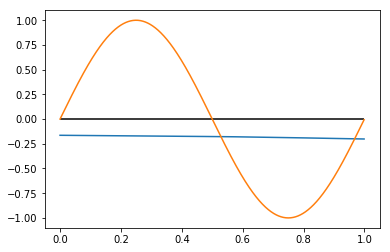

In [123]:
# plt.plot(*data.evaluate(module))
plt.plot(*data.evaluate(hydra_module))
plt.hlines(0, 0, 1)
plt.plot(*data.evaluate())


In [17]:
xs, ys

(array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
        0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
        0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
        0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
        0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
        0.045, 0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053,
        0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062,
        0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071,
        0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 ,
        0.081, 0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089,
        0.09 , 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098,
        0.099, 0.1  , 0.101, 0.102, 0.103, 0.104, 0.105, 0.106, 0.107,
        0.108, 0.109, 0.11 , 0.111, 0.112, 0.113, 0.114, 0.115, 0.116,
        0.117, 0.118, 0.119, 0.12 , 0.121, 0.122, 0.123, 0.124, 0.125,
      

In [30]:
optimizer.step()

In [31]:
list(m.named_parameters())

[('0.bias',
  Parameter containing:
  tensor([ 5.5166,  4.5666, -1.7548, -3.2658], requires_grad=True)),
 ('0.weight_score',
  Parameter containing:
  tensor([[ 5.9078],
          [ 5.1381],
          [-0.7937],
          [-4.6745]], requires_grad=True)),
 ('1.weight',
  Parameter containing:
  tensor([[-12.9988,   3.0419,   8.0672,  -7.9950]], requires_grad=True)),
 ('1.bias',
  Parameter containing:
  tensor([-9.5895], requires_grad=True))]